#### 提出用 input

In [2]:
# n = int(input())
# x, y, r = [], [], []
# for i in range(n):
#     xi, yi, ri = map(int, input().split())
#     x.append(xi)
#     y.append(yi)
#     r.append(ri)

#### 関数の定義

In [25]:
def getArea(rec):
    """
    長方形の面積を取得
    input: (x_min, y_min, x_max, y_max)
    """
    return((rec[2] - rec[0]) * (rec[3] - rec[1]))

    
def check_overlap_line(min1, max1, min2, max2):
    """
    区間 [min1, max1] と [min2, max2] が重なりを持つか判定
    端点を共有することは許容
    """
    assert min1 < max1, 'min1 >= max1'
    assert min2 < max2, 'min2 >= max2'
    overlap_line = False
    if all([min1 + 1 >= min2, min1 + 1 <= max2]):
        overlap_line = True
    elif all([max1 - 1 >= min2, max1 - 1 <= max2]):
        overlap_line = True
    elif all([min2 + 1 >= min1, min2 + 1 <= max1]):
        overlap_line = True
    elif all([max2 - 1 >= min1, max2 - 1 <= max1]):
        overlap_line = True
    return(overlap_line)
    

def check_overlap_rect(rect, i):
    """
    i 番目の長方形が他の長方形と重なるか判定
    """
    rec_i = rect[i]
    rect_overlap = False
    for j in range(len(rect)):
        if i != j:
            rec_j = rect[j]
            x_overlap = check_overlap_line(rec_i[0], rec_i[2], rec_j[0], rec_j[2])
            y_overlap = check_overlap_line(rec_i[1], rec_i[3], rec_j[1], rec_j[3])
            rect_overlap = all([x_overlap , y_overlap])
            if rect_overlap:
                break
    return(rect_overlap)
    

def expand_check(rect, i, new_rec, r):
    """
    rect[i] を new_rec に置き換えられるかをチェックする
    確認事項：面積がオーバーしない・領域が重ならない
    拡張できる場合には書き替えた rect を返す
    """
    flag = False
    new_rect = rect.copy()
    new_rect[i] = new_rec
    if getArea(new_rect[i]) <= r[i]:
        if not check_overlap_rect(new_rect, i):
            rect = new_rect
            flag = True
    return(flag, rect)

def expand_check2(rect, i, new_rec, r):
    """
    rect[i] を new_rec に置き換えられるかをチェックする
    確認事項：面積のスコアが高まる・領域が重ならない
    拡張できる場合には書き替えた rect を返す
    """
    flag = False
    previous_area = getArea(rect[i])
    previous_score = min(previous_area, r[i]) / max(previous_area, r[i])
    
    new_rect = rect.copy()
    new_rect[i] = new_rec
    new_area = getArea(new_rect[i])
    new_score = min(new_area, r[i]) / max(new_area, r[i])
    
    if previous_score > new_score:
        if not check_overlap_rect(new_rect, i):
            rect = new_rect
            flag = True
    return(flag, rect)
    

def reduce_expand_step(expand_steps, i, ratio):
    """
    expand_steps を 1/ratio に減少させる
    もとが 1 の場合はそれ以上拡張できない状態を表す 0 とする
    """
    assert ratio >= 2, 'error, ratio < 2'
    if expand_steps[i] >= ratio:
        expand_steps[i] = int(round(expand_steps[i] / ratio))
    elif expand_steps[i] >= 2:
        expand_steps[i] = 1
    else:
        expand_steps[i] = 0
    return(expand_steps)
    
def generateAnswer(rect):
    for i in range(len(rect)):
        print(' '.join(map(str, rect[i])))

In [35]:
# 提出時は不要
import matplotlib.pyplot as plt
import numpy as np
import cv2
def visualize(rect):
    img = generate_img(rect)
    if np.max(img) <= 1:
        img = (img * 255)
        img = cv2.resize(img, None, fx = 0.1, fy = 0.1) # 縮小して表示
        plt.figure(figsize = (8, 8))
        plt.imshow(img)
        plt.gray()
        plt.show()
    else:
        print('Error: image includes overlapped area(s)')
        
# 長方形を画像で表現
def generate_img(rect):
    img = np.zeros((size, size), dtype = np.uint8)
    for rec in rect:
        img[rec[1]:rec[3], rec[0]:rec[2]] += 1
    return(img)


In [36]:
# input 提出時は不要
with open('AHC001.txt') as f:
    lines = f.read().split('\n')

x, y, r = [], [], []

for i, l in enumerate(lines):
    if i == 0:
        n = int(l)
    else:
        if i <= n:
            xi, yi, ri = map(int, l.split())
            x.append(xi)
            y.append(yi)
            r.append(ri)

#### 拡張

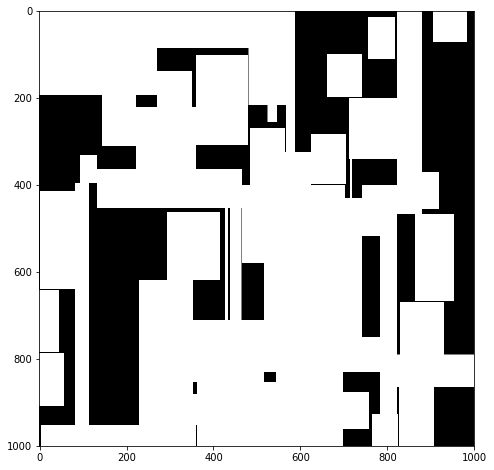

In [37]:
size = 10000 # 外枠の正方形の一辺

# 初期条件の設定
initial_step = 100 # 拡張幅
expand_steps = [initial_step] * n

# 1 辺 1 の正方形を作成
# 与えられる (x, y) に重複はないので，この段階では領域は重ならない
# 長方形は，(x_min, y_min, x_max, y_max) で表記
rect = []
for i in range(n):
    points = x[i], y[i], x[i] + 1, y[i] + 1
    rect.append(points)
    

jmax = 1000
reduce_ratio = 3

for j in range(jmax):
    if max(expand_steps) == 0:
        break
    else:
        for i in range(len(rect)):

            rec = rect[i]
            step = expand_steps[i]
            if step >= 1:
                
                # 長方形が拡張されたかをモニターする
                expandeed = False
                
                # まずは正方形で拡張を試みる
                new_rec = max(0, rec[0] - step), max(0, rec[1] - step), min(rec[2] + step, size), min(rec[3] + step, size)
                expanded, rect = expand_check(rect, i, new_rec, r)                
                
                # 正方形での拡張ができない場合は，一方向ずつ拡張を試みる
                if not expanded:
                
                    # 左に拡張
                    if rec[0] >= 1:
                        new_rec = max(0, rec[0] - step), rec[1], rec[2], rec[3]
                        flag, rect = expand_check(rect, i, new_rec, r)  
                        if flag:
                            expanded = True
                    # 右に拡張
                    if rec[2] <= size - 1:
                        new_rec = rec[0], rec[1], min(rec[2] + step, size), rec[3]
                        flag, rect = expand_check(rect, i, new_rec, r)  
                        if flag:
                            expanded = True
                    # 上に拡張
                    if rec[1] >= 1:
                        new_rec = rec[0], max(0, rec[1] - step), rec[2], rec[3]
                        flag, rect = expand_check(rect, i, new_rec, r)  
                        if flag:
                            expanded = True
                    # 下に拡張
                    if rec[3] <= size - 1:
                        new_rec = rec[0], rec[1], rec[2], min(rec[3] + step, size)
                        flag, rect = expand_check(rect, i, new_rec, r)  
                        if flag:
                            expanded = True

                # どの方向にも拡張できない場合は，expand_step を減らす
                if not expanded:
                    reduce_expand_step(expand_steps, i, reduce_ratio)
                    
# 2nd check
# r を超えてもスコアが上がる場合には拡張
# expand_steps = [1] * n
for i in range(len(rect)):
    rec = rect[i]
#     step = expand_steps[i]
    step = 1
    
    # 左に拡張
    if rec[0] >= 1:
        new_rec = max(0, rec[0] - step), rec[1], rec[2], rec[3]
        _, rect = expand_check2(rect, i, new_rec, r)  
    # 右に拡張
    if rec[2] <= size - 1:
        new_rec = rec[0], rec[1], min(rec[2] + step, size), rec[3]
        _, rect = expand_check2(rect, i, new_rec, r)  
    # 上に拡張
    if rec[1] >= 1:
        new_rec = rec[0], max(0, rec[1] - step), rec[2], rec[3]
        _, rect = expand_check2(rect, i, new_rec, r)  
    # 下に拡張
    if rec[3] <= size - 1:
        new_rec = rec[0], rec[1], rec[2], min(rec[3] + step, size)
        _, rect = expand_check2(rect, i, new_rec, r)  
                    
# generateAnswer(rect)
visualize(rect)

In [40]:
round(sum([round(getArea(rect[i])/r[i], 3) for i in range(n)]) / n, 3)

0.824

In [32]:
i = 0
rec = rect[i]
print('rec:', rec)
step = 100
new_rec = max(0, rec[0] - step), max(0, rec[1] - step), min(rec[2] + step, size), min(rec[3] + step, size)
print('new_rec:', new_rec)
new_rect = rect.copy()
new_rect[i] = new_rec
print('area check:', getArea(new_rect[i]) <= r[i])
print('overlap check', check_overlap_rect(new_rect, i))

rec: (1875, 326, 1944, 395)
new_rec: (1775, 226, 2044, 495)
area check: True
overlap with 29
overlap check True
